In [1]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
from sklearn.decomposition import TruncatedSVD, PCA
import math 
from outliers import smirnov_grubbs as grubbs
sns.set_style('white')

workspace_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/AUG5'
#workspace_dir  = '/scr/malta3/workspace/project_iron/phenotypic'
pheno_dir      = os.path.join(workspace_dir, 'phenotypic')
clinical_dir   = os.path.join(workspace_dir, 'DF_clinical')
save_fig_dir   = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v2'

dpi = 50
pca_mult = 10
cmap_b = ["#1300ff", "#87d6e9"]

In [2]:
def get_df(popname):
    df = pd.read_csv(os.path.join(pheno_dir, 'df_%s_qc.csv'%popname),index_col = 0)
    return df 

controls = get_df('controls')
patients = get_df('patients')


In [3]:
def detect_outlier_subjects(df,measure,m=2):
    upper = np.mean(df[measure]) + m * np.std(df[measure])
    lower = np.mean(df[measure]) - m * np.std(df[measure])

    for subject in df.index:
        if df.loc[subject][measure] > upper:
            print subject
        elif df.loc[subject][measure] < lower:
            print subject

def grubbs_outliers(df, measure, alpha = 0.15):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 

def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]


def gESD_outliers(df, measure, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def gESD_outliersx(df, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df,maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def sortdf(df,m):
    return df.sort(m)[m]
 
def plot_partial_correlation(data, x, y,xlim = None, ylim = None, regressors = None, color = None, annotate = 0, fig_name = None, 
                             dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1,
                             plot_marg = 1, ci = 95, lstyle='-',lw=2.5):
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    df = pd.concat([df_reg, data[x], data[y]], axis=1).dropna()
    
    # inititlize grid and plot regression and margins 
    grid = sns.JointGrid(x, y, data=df,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
    
    if plot_marg:
        grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, fit_reg=fit_reg, scatter= scatter, color = color, x_partial = df[regressors], y_jitter = jitter, 
                    ci = ci, line_kws={'linestyle': lstyle, 'lw':lw}, scatter_kws={"s": 25})
    if labels:
        grid.set_axis_labels()
        #grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels()
    
    ## calculate regression parameters 
    
    formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 7)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    plt.ylabel(y)
    plt.xlabel(x)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    if annotate == 1:
        annotate = (plt.xlim()[1]*0.6,  plt.ylim()[1]*0.95)
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    elif annotate == 0:
        pass
    else:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    
    grid.set_axis_labels()
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    
    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)
    

    print pcor, p_val
    return result


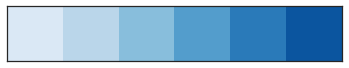

In [4]:
sns.palplot(sns.color_palette("Blues"))
bmap = sns.color_palette("Blues")

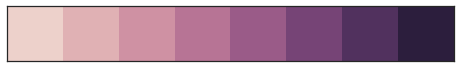

In [5]:
sns.palplot(sns.cubehelix_palette(8))
cube = sns.cubehelix_palette(8)

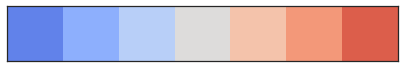

In [6]:
sns.palplot(sns.color_palette("coolwarm", 7))
coolwarm = sns.color_palette("coolwarm", 7)

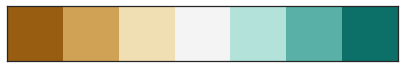

In [7]:
sns.palplot(sns.color_palette("BrBG", 7))
bgmap = sns.color_palette("BrBG", 7)

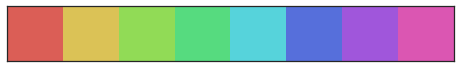

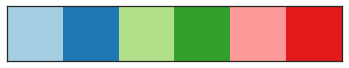

In [8]:
sns.palplot(sns.color_palette("hls", 8))
sns.palplot(sns.color_palette("Paired"))

blue = sns.color_palette("Paired")[1]
green = sns.color_palette("Paired")[3]
red = sns.color_palette("Paired")[5]

# Correlation Matrix

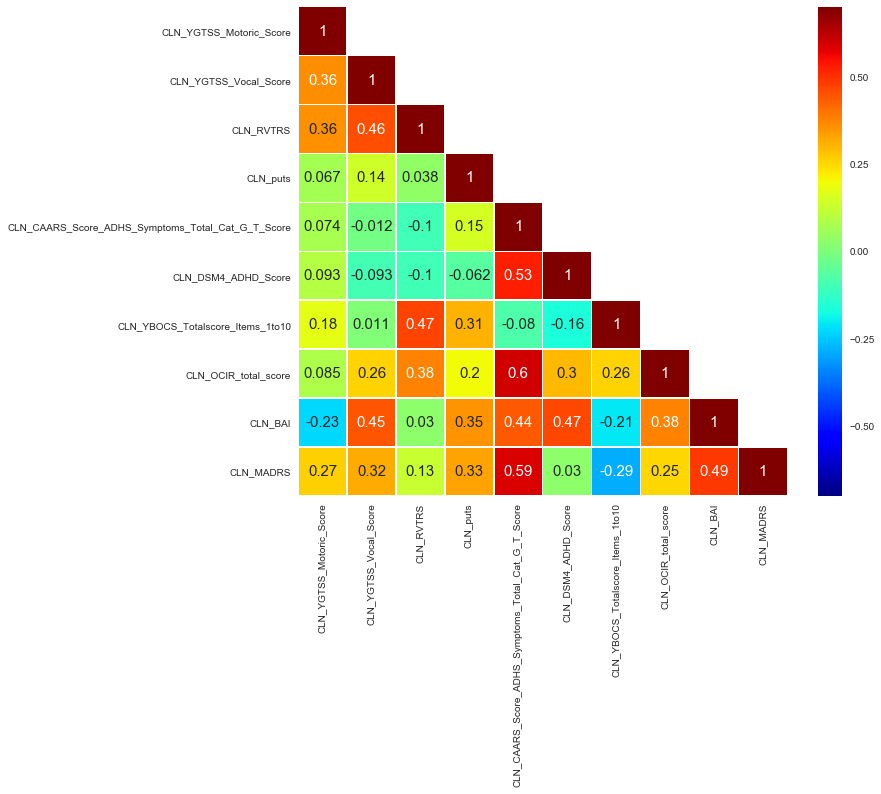

In [231]:
df = patients.drop([], axis = 0 )
cln_metrics = [df['CLN_YGTSS_Motoric_Score'],
               df['CLN_YGTSS_Vocal_Score'], 
               df['CLN_RVTRS'],
               df['CLN_puts'],
               #df['CLN_qol_score'],
               #df['CLN_YGTSS_Total_Tic_Score'],
               #df['CLN_YGTSS_Total_Score_incl_Impairment'],
               df['CLN_CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score'],
               df['CLN_DSM4_ADHD_Score'], 
               df['CLN_YBOCS_Totalscore_Items_1to10'], 
               df['CLN_OCIR_total_score'],
               #df['CLN_BDI12'],  
               df['CLN_BAI'],  
               df['CLN_MADRS'],
              ]
df = pd.concat(cln_metrics,  axis=1)
corr = df.corr('spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask, k = 1)] = True
f, ax = plt.subplots(figsize=(11, 9))
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap = 'jet'
sns.heatmap(corr, cmap = cmap ,
            mask=mask,square=True, vmin = -0.7, vmax = 0.7,
            linewidths=.5, cbar_kws={"shrink": 1}, ax=ax, annot = True, annot_kws={"size":15})
#ticks  =  [x +0.5 for x in range(0,9)]
labelx = ['YGTSS-Motor', 'YGTSS-Vocal', 'RVTRS', 'PUTS', 'QOL', 'DSM-IV-ADHD', 'YBOCS', 'OCI-R' 'BDI-12', 'BAI',]
#plt.xticks(ticks, labelx)
#plt.yticks(ticks[::-1], labelx)

# MOTOR

CLN PC1 explained variance: [  2.90954102e-01   2.11515524e-01   1.72289035e-01   1.16841215e-01
   1.00789939e-01   8.20178667e-02   2.55923189e-02   1.20218744e-32]
explained variance by PC1,2,3= 0.674758661148

BE9P
-0.515 0.033525
CLN_YGTSS_Motoric_Score 0.22 0.3171
CLN_YGTSS_Vocal_Score 0.23 0.2885
CLN_RVTRS 0.15 0.501
CLN_puts 0.54 0.0079
CLN_DSM4_ADHD_Score -0.74 0.0001
CLN_OCIR_total_score 0.13 0.5602
CLN_BDI12 0.41 0.0537
CLN_MADRS 0.45 0.032


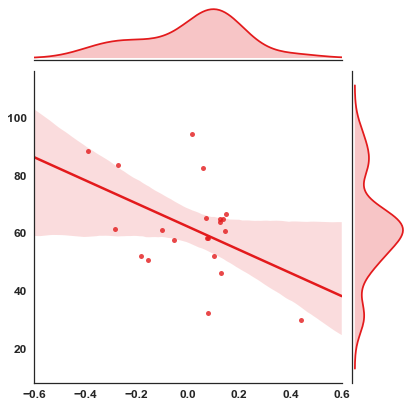

In [356]:
# Take PCA of quality metrics
from sklearn.decomposition import TruncatedSVD, KernelPCA
df = patients.drop([], axis = 0 )
cln_metrics = ['CLN_YGTSS_Motoric_Score',
               'CLN_YGTSS_Vocal_Score',#, 
               #'CLN_YGTSS_Total_Score_incl_Impairment',
               #'CLN_YGTSS_Total_Tic_Score',
               'CLN_RVTRS',
               #'CLN_qol_score',
               'CLN_puts',
               'CLN_DSM4_ADHD_Score',
               #'CLN_CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score',
               #'CLN_YBOCS_Totalscore_Items_1to10', 
               'CLN_OCIR_total_score',
               #'CLN_BAI', 
               'CLN_BDI12', 
               'CLN_MADRS'
              ]

#df = pd.concat([df[cln] for cln in cln_metrics], axis = 1).dropna()
#df = pd.concat([df,patients.ALL, patients.Age, patients.Gender, patients.QC_PCA], axis =1)

pca = PCA(n_components=8)
#data = np.array(np.asarray([df[cln] for cln in cln_metrics]))
data = np.array(np.asarray([preprocessing.scale(df[cln]) for cln in cln_metrics]))
pca.fit(data)
df['CLN_PCA'] = pca.components_[1, :] *-1#pca_mult
print 'CLN PC1 explained variance:',pca.explained_variance_ratio_
var =  pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1] + pca.explained_variance_ratio_[2] 
print 'explained variance by PC1,2,3=',var
print ''
detect_outlier_subjects(df,'CLN_PCA',m=2)

plot_partial_correlation(df.drop(['BE9P', 'RL7P'],axis=0), 
                        'CLN_PCA', 'ALL', 
                         xlim = (-.6,.6), 
                         ylim = None, regressors = ['Age','Gender','QC_PCA'], 
                         color = red, #annotate = (.23,0.3),
                         dpi = 100, labels = 0, jitter = 0.0001,fit_reg=True, scatter=1,
                         plot_marg = 1, ci = 95, lstyle='-',lw=2.5,
                         fig_name = 'clinical_PCA_chi_tics.png'
                        )
for i in cln_metrics:
    print i, np.round(pearsonr(df.CLN_PCA, df[i])[0],2), np.round(pearsonr(df.CLN_PCA, df[i])[1],4)

(0, 5)

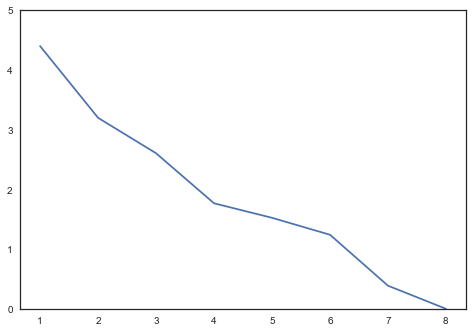

In [349]:
plt.plot(range(1,9) , pca.explained_variance_)
plt.ylim(0,5)

In [350]:
df.CLN_PCA

BE9P    0.181570
HJEP    0.119471
RMJP   -0.445075
BATP    0.062081
LT5P   -0.253146
CM5P    0.251838
CF1P   -0.173374
SM6U    0.229729
RL7P   -0.191284
EB2P    0.119362
SGKP   -0.036787
HHQP   -0.421211
SA5U    0.058133
THCP    0.055568
PC5P    0.150523
SBQP   -0.108426
TT3P    0.174040
NT6P    0.094366
CB4P    0.186855
YU1P    0.046711
RA9P    0.256599
SULP   -0.357561
KDDP    0.000017
Name: CLN_PCA, dtype: float64

In [351]:
df.ALL.sort_values()

SM6U     29.82075
PC5P     32.08300
BE9P     39.86975
YU1P     46.13650
LT5P     50.66750
NT6P     51.76525
CM5P     51.87500
HJEP     57.61400
KDDP     58.22600
EB2P     58.31400
BATP     60.42875
TT3P     60.97450
SA5U     61.21525
RMJP     63.81950
HHQP     64.62225
SGKP     64.69900
THCP     65.11825
RA9P     66.65850
CB4P     82.44775
CF1P     83.56725
SBQP     88.33800
SULP     94.14075
RL7P    110.38825
Name: ALL, dtype: float64

In [ ]:
csv = pd.read_csv('/Users/kanaan/Desktop/CSV.csv', index_col=0)
csv.ALL

ValueError: could not convert string to float: 

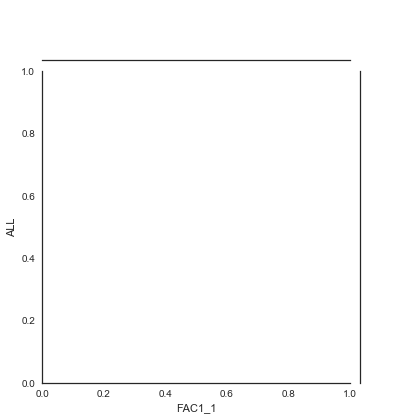

In [179]:
plot_partial_correlation(csv.drop(['RMJP'],axis=0), 
                        'FAC1_1', 'ALL', 
                         xlim = None,#(-8,8), 
                         ylim = None, regressors = ['Age','QC_PCA'], 
                         color = red, #annotate = (.23,0.3),
                         dpi = 100, labels = 0, jitter = 0.0001,fit_reg=True, scatter=1,
                         plot_marg = 1, ci = 95, lstyle='-',lw=2.5,
                        )

CLN PC1 explained variance: [  4.89040133e-01   2.81932890e-01   2.29026977e-01   1.51450051e-32]
-0.474 0.132286
CLN_YGTSS_Motoric_Score (-0.2978946453373672, 0.1781419334333284)
CLN_YGTSS_Vocal_Score (-0.37946994986073546, 0.08154189994048501)
CLN_RVTRS (-0.5773761894638596, 0.0048976013270154032)
CLN_puts (0.7596926085282405, 4.1104983234231749e-05)


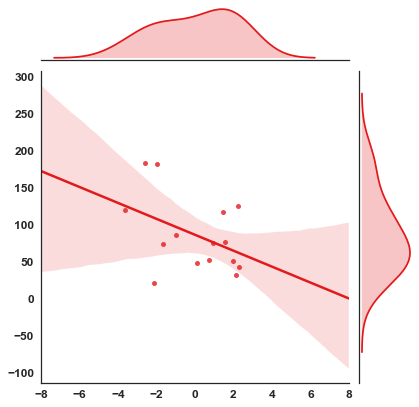

In [12]:
# Take PCA of quality metrics
from sklearn.decomposition import TruncatedSVD, KernelPCA
df = patients.drop(['SA5U'], axis = 0 )
cln_metrics = ['CLN_YGTSS_Motoric_Score',
               'CLN_YGTSS_Vocal_Score',#, 
               'CLN_RVTRS',
               'CLN_puts',
               #'CLN_DSM4_ADHD_Score',
               #'CLN_YBOCS_Totalscore_Items_1to10', 
               #'CLN_OCIR_tota_score',
               #'CLN_BDI12', 
               #'CLN_BAI', 
               #'CLN_MADRS'
              ]
pca = PCA(n_components=4)
data = np.array(np.asarray([df[cln] for cln in cln_metrics]))
data = np.array(np.asarray([preprocessing.scale(df[cln]) for cln in cln_metrics]))
pca.fit(data)
df['CLN_PCA'] = pca.components_[0, :] *pca_mult
print 'CLN PC1 explained variance:',pca.explained_variance_ratio_

detect_outlier_subjects(df,'CLN_PCA',m=2)

plot_partial_correlation(df.drop([],axis=0), 
                        'CLN_PCA', 'CLN_Ferritin', 
                         xlim = (-8,8), 
                         ylim = None, regressors = ['Age','Gender','QC_PCA'], 
                         color = red, #annotate = (.23,0.3),
                         dpi = 100, labels = 0, jitter = 0.0001,fit_reg=True, scatter=1,
                         plot_marg = 1, ci = 95, lstyle='-',lw=2.5,
                         fig_name = 'clinical_PCA_cln_tics.png'
                        )

for i in cln_metrics:
    print i, pearsonr(df.CLN_PCA, df[i])

In [109]:
df.CLN_Ferritin

BE9P     86.07
HJEP     76.43
RMJP       NaN
BATP     50.67
LT5P    120.10
CM5P     42.69
CF1P     20.51
SM6U    124.60
RL7P     48.19
EB2P     73.03
SGKP       NaN
HHQP    182.40
THCP    117.10
PC5P     31.87
SBQP       NaN
TT3P       NaN
NT6P     51.63
CB4P       NaN
YU1P       NaN
RA9P       NaN
SULP    183.80
KDDP     74.30
Name: CLN_Ferritin, dtype: float64

In [45]:
df.CLN_PCA.sort_values()

RMJP   -4.786096
LT5P   -3.409057
CF1P   -3.096862
SBQP   -2.721642
SGKP   -1.452640
HHQP   -1.361721
SULP   -1.199666
EB2P   -0.397416
YU1P    0.054513
CB4P    0.151161
SA5U    0.151161
BE9P    0.388942
NT6P    0.404135
TT3P    0.526468
KDDP    0.599200
PC5P    1.122265
SM6U    1.574894
THCP    1.678340
BATP    2.476087
CM5P    2.623232
HJEP    3.153096
RA9P    3.521604
Name: CLN_PCA, dtype: float64

# Non-Motor

In [119]:
# Take PCA of quality metrics
from sklearn.decomposition import TruncatedSVD, KernelPCA
df = patients.drop(['RL7P'], axis = 0 )
df = pd.concat([controls, patients.drop(['RL7P'], axis = 0 )])
cln_metrics = ['CLN_YGTSS_Motoric_Score',
               'CLN_YGTSS_Vocal_Score',#, 
               #'CLN_RVTRS',
               'CLN_puts',
               #'CLN_qol_score',
               'CLN_DSM4_ADHD_Score',
               'CLN_YBOCS_Totalscore_Items_1to10', 
               #'CLN_OCIR_tota_score',
               'CLN_BDI12', 
               'CLN_BAI', 
               #'CLN_MADRS'
              ]
pca = PCA(n_components=5)
data = np.array(np.asarray([df[cln] for cln in cln_metrics]))
data = np.nannp.array(np.asarray([preprocessing.scale(df[cln]) for cln in cln_metrics]))
pca.fit(data)
df['CLN_PCA'] = pca.components_[3, :] * -1
print 'CLN PC1 explained variance:',pca.explained_variance_ratio_

detect_outlier_subjects(df,'CLN_PCA',m=2)

plot_partial_correlation(df.drop(['HHQP'],axis=0), 
                        'CLN_PCA', 'ALL', 
                         xlim = None,#(-7,7), 
                         ylim = None, regressors = ['Age','Gender','QC_PCA'], 
                         color = green, annotate = (.23,0.3),
                         dpi = 100, labels = 0, jitter = 0.0001,fit_reg=True, scatter=1,
                         plot_marg = 1, ci = 95, lstyle='-',lw=2.5,
                         fig_name = 'clinical_PCA_chi_comorbid.png'
                        )
print ''
for i in cln_metrics:
    print i, np.round(pearsonr(df.CLN_PCA, df[i])[0],2), np.round(pearsonr(df.CLN_PCA, df[i])[1],4)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [234]:
for i in cln_metrics:
    print i, pearsonr(df.CLN_PCA, df[i])

CLN_DSM4_ADHD_Score (0.27956641532929988, 0.20765198863519904)
CLN_YBOCS_Totalscore_Items_1to10 (-0.76814253151379308, 2.9860122104191096e-05)
CLN_OCIR_tota_score (-0.15898176121643348, 0.47976687684477159)
CLN_BDI12 (0.54121906654890473, 0.0092906730846105384)
CLN_BAI (0.46706494883930527, 0.028412112417341383)
CLN_MADRS (0.73136434651869131, 0.00011003816296986397)


In [176]:
print np.dot( pca.components_[0], (df.CLN_puts / np.linalg.norm(df.CLN_puts)))
print np.dot( pca.components_[0], (df.CLN_YGTSS_Vocal_Score / np.linalg.norm(df.CLN_puts)))
print np.dot( pca.components_[0], (df.CLN_YGTSS_Motoric_Score / np.linalg.norm(df.CLN_puts)))
print np.dot( pca.components_[0], (df.CLN_RVTRS / np.linalg.norm(df.CLN_puts)))


0.227335758081
-0.109388409422
-0.0643483584328
-0.137530767107


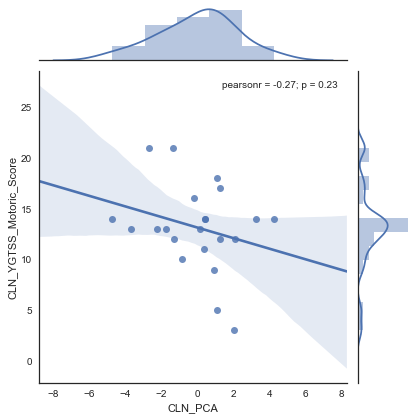

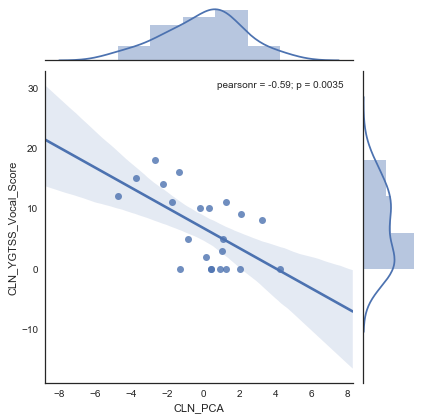

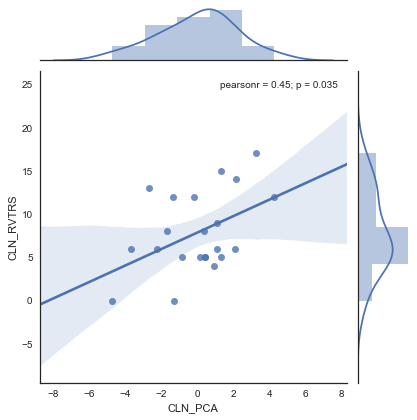

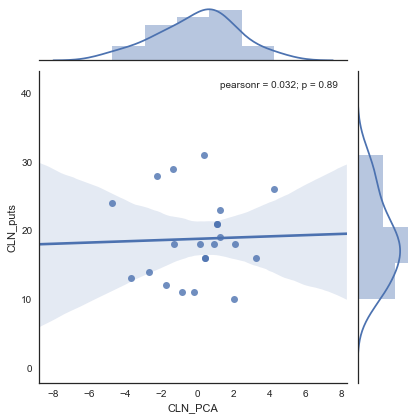

In [177]:
for i in cln_metrics:
    sns.jointplot(df['CLN_PCA'], df[i], kind = 'reg')

In [69]:
pca.components_[0]

array([ 0.00636007,  0.32677988, -0.52121587,  0.23380396,  0.26557884,
       -0.3542912 ,  0.14983221, -0.06319706, -0.17970005, -0.15770385,
        0.00306182,  0.15759138,  0.10371981, -0.31247773,  0.03948043,
        0.03745313,  0.00306182,  0.00145386,  0.35704728, -0.14530874,
        0.04866998])

In [ ]:
# Take PCA of quality metrics
from sklearn.decomposition import TruncatedSVD, KernelPCA
df = patients.drop([], axis = 0 )
cln_metrics = ['CLN_YGTSS_Motoric_Score',
               'CLN_YGTSS_Vocal_Score',#, 
               #'CLN_RVTRS',
               'CLN_puts',
               #'CLN_DSM4_ADHD_Score',
               #'CLN_YBOCS_Totalscore_Items_1to10', 
               #'CLN_OCIR_tota_score',
               #'CLN_BDI12', 
               #'CLN_BAI', 
               #'CLN_MADRS'
              ]
pca = PCA(n_components=3)
data = np.array(np.asarray([df[cln] for cln in cln_metrics]))
#data = np.array(np.asarray([preprocessing.scale(df[cln]) for cln in cln_metrics]))
pca.fit(data)
df['CLN_PCA'] = pca.components_[0, :] *pca_mult
print 'CLN PC1 explained variance:',pca.explained_variance_ratio_

pca = PCA(n_components=3)
chi_vars = ['L_Caud','L_Puta','L_Pall','L_SN','L_STN']
chi_vars = ['Caud','Puta','Pall','SN','STN', 'DN']
pca.fit(np.array(np.asarray([df[chi] for chi in chi_vars])))
df['BG_PCA'] = pca.components_[0, :] *pca_mult
print 'BG PC1 explained variance:',pca.explained_variance_ratio_

detect_outlier_subjects(df,'BG_PCA',m=2)
detect_outlier_subjects(df,'CLN_PCA',m=2)

plot_partial_correlation(df.drop(['RL7P', 'LT5P'], axis = 0), 
                        'CLN_PCA', 'ALL', 
                         xlim = (-7,7), 
                         ylim = None, regressors = ['Age','Gender','QC_PCA'], 
                         color = blue, annotate = (.23,0.3),
                         dpi = 100, labels = 0, jitter = 0.0001,fit_reg=True, scatter=1,
                         plot_marg = 1, ci = 95, lstyle='-',lw=2.5,
                         fig_name = 'clinical_PCA_chi_tics.png'
                        )


In [10]:
# Take PCA of quality metrics
from sklearn.decomposition import TruncatedSVD
df = patients.drop([], axis = 0 )
cln_metrics = ['CLN_YGTSS_Motoric_Score',
               'CLN_YGTSS_Vocal_Score',#, 
               #'CLN_RVTRS',
               'CLN_puts',
               #'CLN_DSM4_ADHD_Score',
               #'CLN_YBOCS_Totalscore_Items_1to10', 
               #'CLN_OCIR_tota_score',
               #'CLN_BDI12', 
               #'CLN_BAI', 
               #'CLN_MADRS'
              ]
pca = PCA(n_components=3)
data = np.array(np.asarray([df[cln] for cln in cln_metrics]))
data = np.array(np.asarray([preprocessing.scale(df[cln]) for cln in cln_metrics]))
pca.fit_transform(data)
df['CLN_PCA1'] = pca.components_[0, :] *pca_mult
df['CLN_PCA2'] = pca.components_[1, :] *pca_mult
df['CLN_PCA3'] = pca.components_[2, :] *pca_mult
print 'CLN PC1 explained variance:',pca.explained_variance_ratio_


CLN PC1 explained variance: [  6.37032956e-01   3.62967044e-01   1.73082161e-32]


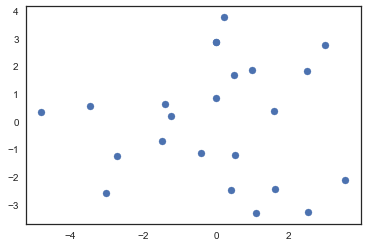

In [918]:
plt.scatter(df['CLN_PCA1'].sort_index(), df['CLN_PCA2'].sort_index())

In [921]:
np.array(df['CLN_PCA1'].sort_index()).T

array([  2.53076113e+00,   4.05648316e-01,  -3.99313633e-03,
        -3.03459073e+00,   2.50079478e+00,  -3.99412766e-01,
        -1.41518360e+00,   2.99975789e+00,   4.87097715e-01,
        -3.46173310e+00,   2.27447313e-01,   9.98919264e-01,
         3.55117444e+00,   1.09459049e+00,  -4.80897508e+00,
        -3.99313633e-03,  -2.71348493e+00,  -1.47839539e+00,
         1.62640604e+00,  -1.24695494e+00,   1.60216256e+00,
         5.34564980e-01,   7.39191173e-03])

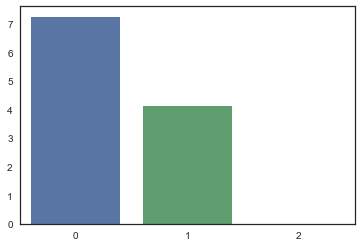

In [868]:
pca = PCA(n_components=3)
data = np.array(np.asarray([df[cln] for cln in cln_metrics]))
data = np.array(np.asarray([preprocessing.scale(df[cln]) for cln in cln_metrics]))
pca.fit(data)
#plt.scatter(pca.components_[0, :],pca.components_[1, :] )
sns.barplot([0,1,2], pca.explained_variance_)

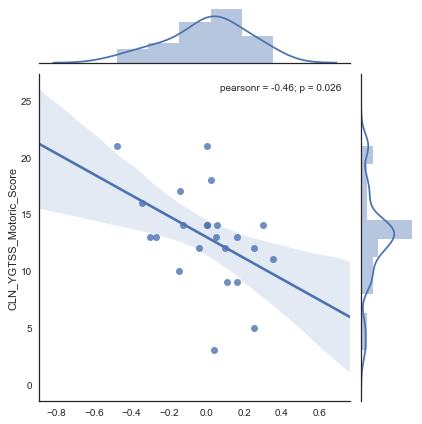

In [871]:
sns.jointplot(pca.components_[0, :], df.CLN_YGTSS_Motoric_Score, kind = 'reg')

In [680]:
from sklearn.decomposition import FactorAnalysis

fa_naive = FactorAnalysis(1)
fa_naive.fit(data)
fa_naive.components_, fa_naive.noise_variance_

(array([[ 0.14731241,  0.79067449, -1.26942656,  0.71259537, -0.90885169,
          0.66646458, -0.77347064,  0.45942195, -0.08354845, -0.36961336,
         -0.36856675, -0.00517322,  0.44035734,  0.26854073, -0.69657133,
          0.1620527 ,  0.04629875, -0.00517322,  0.00258704,  0.96920475,
         -0.31814138,  0.13302648]]),
 array([  2.85423785e-01,   3.03895132e-01,   2.79633672e-06,
          4.57453388e-01,   3.27071301e-03,   1.25221721e-01,
          3.35206138e-01,   2.55001321e-01,   6.98850699e-02,
          3.58253022e-02,   8.06082772e-03,   2.99861432e-01,
          3.31593597e-03,   1.23925957e-01,   9.32609441e-02,
          7.36143725e-02,   5.42529801e-01,   2.99861432e-01,
          2.06242306e-02,   1.81667489e-01,   1.88495961e-07,
          9.80975638e-02]))

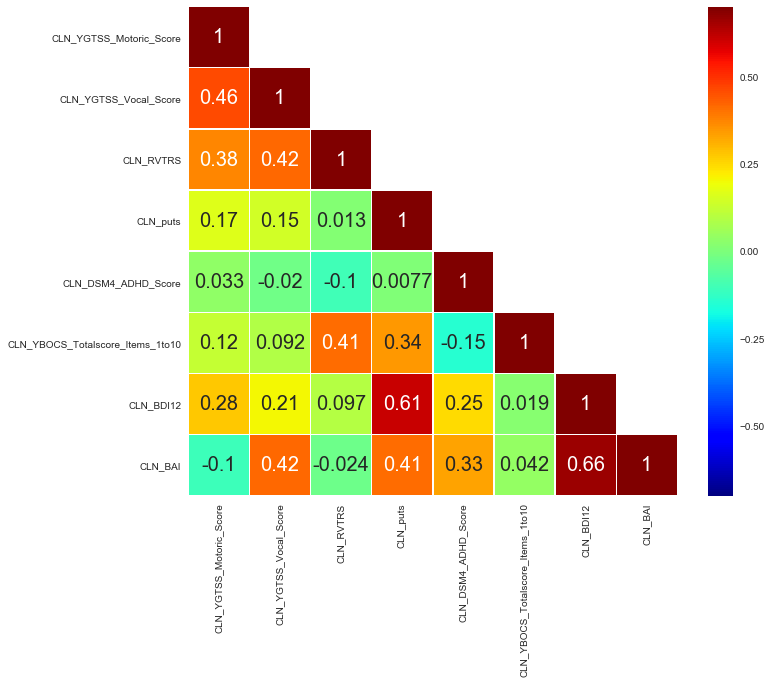

CLN PC1 explained variance: [ 0.43090404  0.28275363  0.20105414]
HHQP
-0.421 0.1885587


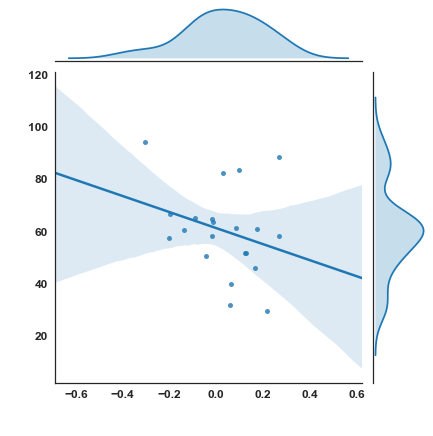

In [164]:
# Take PCA of quality metrics
from sklearn.decomposition import TruncatedSVD, KernelPCA
df = patients.drop(['RL7P'], axis = 0 )
cln_metrics = [#'CLN_YGTSS_Motoric_Score',
               #'CLN_YGTSS_Vocal_Score',#, 
               #'CLN_RVTRS',
               #'CLN_puts',
               'CLN_DSM4_ADHD_Score',
               'CLN_YBOCS_Totalscore_Items_1to10', 
               'CLN_OCIR_tota_score',
               'CLN_BDI12', 
               'CLN_BAI', 
               #'CLN_MADRS'
              ]
pca = PCA(n_components=3)
data = np.array(np.asarray([df[cln] for cln in cln_metrics]))
data = np.array(np.asarray([preprocessing.scale(df[cln]) for cln in cln_metrics]))
pca.fit(data)
df['CLN_PCA'] = pca.components_[0, :] * -1
print 'CLN PC1 explained variance:',pca.explained_variance_ratio_

detect_outlier_subjects(df,'CLN_PCA',m=2)

plot_partial_correlation(df.drop(['HHQP'],axis=0), 
                        'CLN_PCA', 'ALL', 
                         xlim = None,#(-7,7), 
                         ylim = None, regressors = ['Age','Gender','QC_PCA'], 
                         color = blue, annotate = (.23,0.3),
                         dpi = 100, labels = 0, jitter = 0.0001,fit_reg=True, scatter=1,
                         plot_marg = 1, ci = 95, lstyle='-',lw=2.5,
                         fig_name = 'clinical_PCA_chi_nonmotor.png'
                        )


In [166]:
dfx = pd.concat([patients, controls])
pca.fit(np.array(np.asarray([dfx[qc] for qc in ['QI1_MAG', 'EFC_MAG', 'FWHM_MAG']])))
dfx['XX'] = pca.components_[0, :] *pca_mult
print 'PC1 explained variance:',pca.explained_variance_ratio_


PC1 explained variance: [  9.99792883e-01   2.07117194e-04   7.85829438e-33]


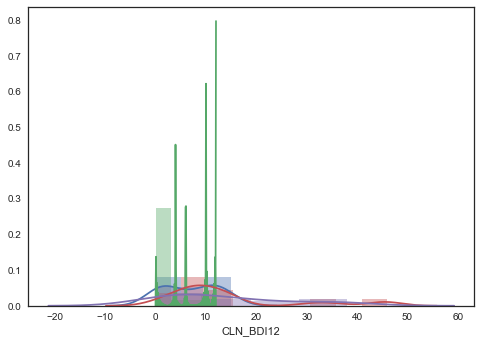

In [167]:
sns.distplot(df.CLN_DSM4_ADHD_Score)
sns.distplot(df.CLN_YBOCS_Totalscore_Items_1to10)
sns.distplot(df.CLN_OCIR_tota_score)
sns.distplot(df.CLN_BDI12)


In [168]:
df.CLN_YBOCS_Totalscore_Items_1to10

BE9P     0.0
HJEP     6.0
RMJP     0.0
BATP     0.0
LT5P     0.0
CM5P     0.0
CF1P     0.0
SM6U     0.0
EB2P     0.0
SGKP     0.0
HHQP    12.0
SA5U     0.0
THCP     0.0
PC5P     0.0
SBQP     0.0
TT3P     0.0
NT6P     0.0
CB4P     0.0
YU1P     0.0
RA9P    10.0
SULP     4.0
KDDP     0.0
Name: CLN_YBOCS_Totalscore_Items_1to10, dtype: float64

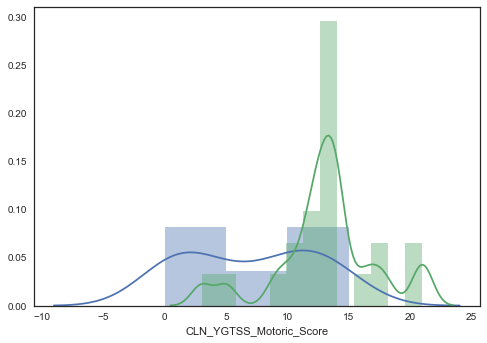

In [169]:
sns.distplot(df.CLN_DSM4_ADHD_Score)
#sns.distplot(df.CLN_RVTRS)
#sns.distplot(df.CLN_YGTSS_Vocal_Score)
sns.distplot(df.CLN_YGTSS_Motoric_Score)


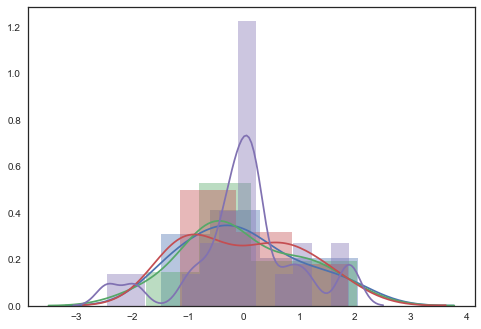

In [170]:
sns.distplot(preprocessing.scale(df.CLN_puts))
sns.distplot(preprocessing.scale(df.CLN_RVTRS))
sns.distplot(preprocessing.scale(df.CLN_YGTSS_Vocal_Score))
sns.distplot(preprocessing.scale(df.CLN_YGTSS_Motoric_Score))
